In [2]:
%cd /data/joohyun7u/project/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/joohyun7u/project/vq2d-lightning


/data/joohyun7u/anaconda3/envs/vqlight3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from IPython.display import Image as IPImage

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule

import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from diffusers.utils import make_image_grid

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import math


def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    if tensor.dim() == 1:
        side_length = int(math.sqrt(tensor.shape[0]))
        if side_length * side_length == tensor.shape[0]:
            tensor = tensor.reshape(side_length, side_length)
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/data/joohyun7u/anaconda3/envs/vqlight3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1087003/473354482.py:56: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [4]:
# path_ckpt = 'outputs/batch/2024-10-30/57242/epoch=56-prob_acc=0.7935.ckpt'
# plm_base = LitModule.load_from_checkpoint(path_ckpt).cuda()
# plm_base.eval()
# plm_base.freeze()

# path_ckpt = 'outputs/batch/2024-10-19/133186/epoch=54-prob_acc=0.7952.ckpt'
# path_ckpt = 'outputs/batch/2024-10-21/133643/epoch=22-prob_acc=0.7899.ckpt'
# path_ckpt = 'outputs/batch/2024-10-30/57242/epoch=56-prob_acc=0.7935.ckpt'
path_ckpt = 'outputs/batch/2024-10-18/132949/epoch=43-prob_acc=0.7532.ckpt'  # loss 없는 거
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

eval_config = hydra.compose(config_name='eval_jh', overrides=[
    f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1',
    f'+model.enable_cls_token_score=true',
    f'+model.cls_norm=false'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

dict_keys(['segment', 'query', 'gt_bboxes', 'gt_probs', 'before_query_mask', 'video_uid', 'clip_uid', 'annotation_uid', 'seg_idxs', 'query_set', 'clip_fps', 'query_frame', 'visual_crop', 'object_title'])


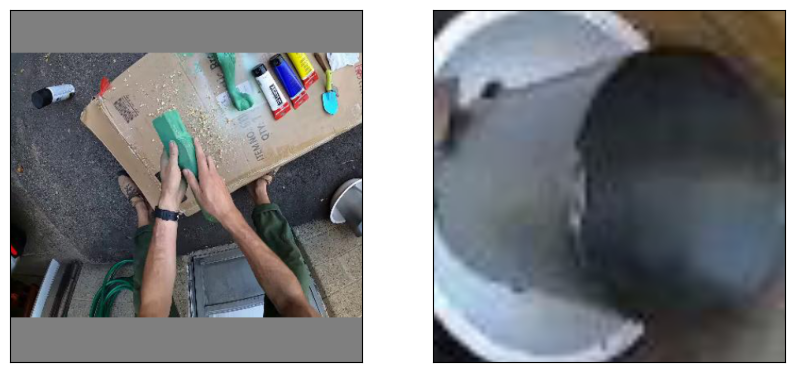

In [5]:
# get
# bidx = 300  # mean iou: 0 vs. 0.450
# bidx = 1307  # mean iou:
# bidx = 2300
# bidx = 2305
bidx = 285

batch = pdm.get_val_sample(idx=bidx)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.cuda()

# viz
print(batch.keys())
seg = rearrange(batch['segment'][0], 't c h w -> t h w c').cpu().numpy()
q = rearrange(batch['query'][0], 'c h w -> h w c').cpu().numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(seg[len(seg) // 2])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax = axes[1]
ax.imshow(q)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [6]:
plm.model.enable_cls_token_score = True
plm.model.cls_norm = False
with torch.inference_mode():
    inputs = dict(**batch)
    inputs['segment'], inputs['query'] = pdm.normalize(inputs['segment'], inputs['query'])
    # output_dict = plm_base.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
    output_dict = plm.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
output_dict.keys()

dict_keys(['feat', 'loss', 'log_dict', 'info_dict', 'pred_dict'])

In [7]:
print(batch['segment'].shape)
print(batch['query'].shape)
print()
t, c, h, w = output_dict['feat']['clip']['backbone'].shape
print(output_dict['feat']['clip']['backbone'].shape)
print(output_dict['feat']['query']['backbone'].shape)
reduce_key = 'late_reduce' if 'late_reduce' in output_dict['feat']['clip'] else 'reduce'
print(output_dict['feat']['clip'][reduce_key].shape)
print(output_dict['feat']['query'][reduce_key].shape)
print(output_dict['feat']['clip']['stx'].shape)
if 'conv' in output_dict['feat']['clip']:
    print(output_dict['feat']['clip']['conv'].shape)
print(output_dict['feat']['clip']['latent_clip_non_cls'].shape)
print(output_dict['feat']['query']['latent_query_cls'].shape)
print(output_dict['feat']['guide']['cls_mask'].shape)
print()
print(f"mean IoU:      {output_dict['log_dict']['iou'].item():.3f}")
print(f"mean prob acc: {output_dict['log_dict']['prob_acc'].item():.3f}")

torch.Size([1, 32, 3, 448, 448])
torch.Size([1, 3, 448, 448])

torch.Size([32, 768, 32, 32])
torch.Size([1, 768, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([32, 1024, 768])
torch.Size([1, 1, 768])
torch.Size([128, 1024, 1024])

mean IoU:      0.806
mean prob acc: 1.000


In [8]:
latent_clip_non_cls = output_dict['feat']['clip']['latent_clip_non_cls']
latent_query_cls =  output_dict['feat']['query']['latent_query_cls']
cls_mask = output_dict['feat']['guide']['cls_mask']
clip_feat = output_dict['feat']['clip']['pe_stx']
query_feat_expanded = output_dict['feat']['query']['pe_stx']
stx_tgt_mask = output_dict['feat']['guide']['stx_tgt_mask']
stx_mem_mask = output_dict['feat']['guide']['stx_mem_mask']

def print_analy(mask):
    print(mask.shape,mask.min(),mask.max(), mask.mean(), mask.std())
    print(mask.topk(7))
    print(mask.topk(7, largest=False))


cls_mask
torch.Size([32, 1024]) tensor(3.3536e-20, device='cuda:0') tensor(0.0172, device='cuda:0') tensor(0.0010, device='cuda:0') tensor(0.0016, device='cuda:0')
torch.return_types.topk(
values=tensor([0.0172, 0.0171, 0.0171, 0.0166, 0.0162, 0.0161, 0.0161, 0.0161, 0.0160,
        0.0159], device='cuda:0'),
indices=tensor([ 2229,  1319, 24723, 21652, 13068, 11405, 11498, 11438, 19603,  1174],
       device='cuda:0'))


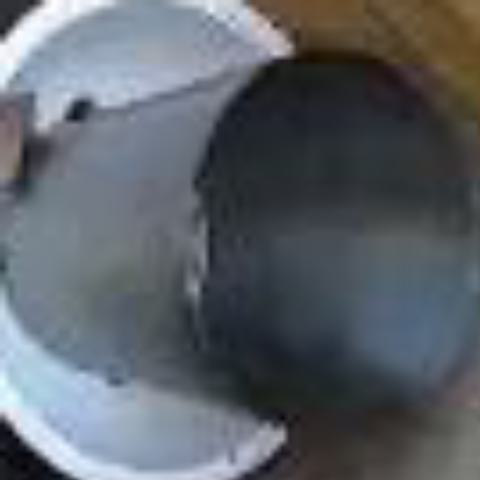

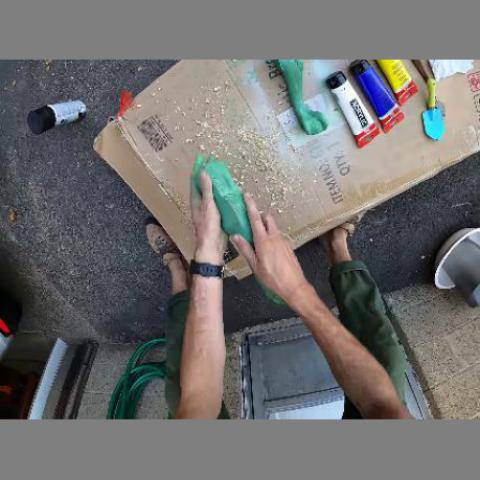

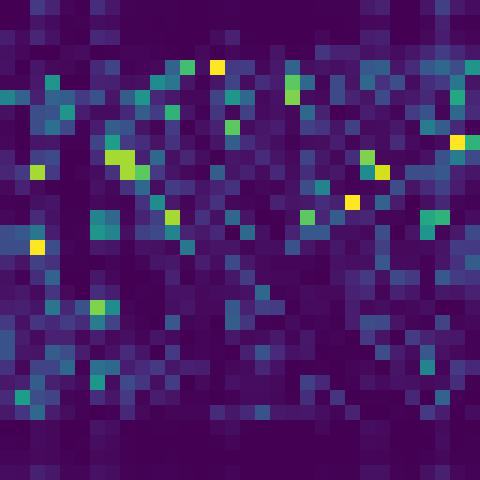

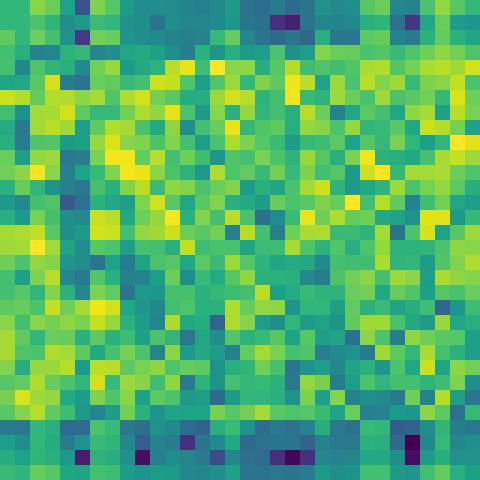

torch.Size([1024]) tensor(2.3500, device='cuda:0') tensor(12.7706, device='cuda:0') tensor(9.0023, device='cuda:0') tensor(1.7039, device='cuda:0')
torch.return_types.topk(
values=tensor([12.7706, 12.7510, 12.7189, 12.7140, 12.6697, 12.5252, 12.4034],
       device='cuda:0'),
indices=tensor([193, 349, 203, 381, 263, 345, 161], device='cuda:0'))
torch.return_types.topk(
values=tensor([2.3500, 2.5899, 2.8386, 2.8579, 3.3830, 3.3958, 3.5221],
       device='cuda:0'),
indices=tensor([955, 979, 987, 969,  51, 965,  50], device='cuda:0'))


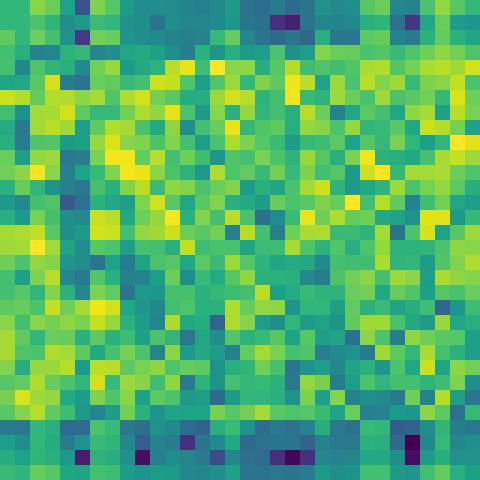

torch.Size([1024]) tensor(2.3500, device='cuda:0') tensor(12.7706, device='cuda:0') tensor(9.0023, device='cuda:0') tensor(1.7039, device='cuda:0')
torch.return_types.topk(
values=tensor([12.7706, 12.7510, 12.7189, 12.7140, 12.6697, 12.5252, 12.4034],
       device='cuda:0'),
indices=tensor([193, 349, 203, 381, 263, 345, 161], device='cuda:0'))
torch.return_types.topk(
values=tensor([2.3500, 2.5899, 2.8386, 2.8579, 3.3830, 3.3958, 3.5221],
       device='cuda:0'),
indices=tensor([955, 979, 987, 969,  51, 965,  50], device='cuda:0'))
tensor(9.0023, device='cuda:0') tensor(9.0023, device='cuda:0') tensor(9.0023, device='cuda:0') tensor(9.0023, device='cuda:0')


In [9]:
import torch.nn.functional as F
def get_cross_cls_attn_score(latent_query, latent_clip, extra=1, extra2=1):
        BT, N, C = latent_clip.shape
        B = latent_query.shape[0]
        T = BT // B
        cls_repair_neighbor = False
        cls_norm = True
        
        if cls_repair_neighbor:
            w = 32
            feat = rearrange(latent_clip, '(b t) (h w) c -> b t h w c', b=B, t=T, w=w)
            neighbor_patches = torch.cat([
                rearrange(feat[:, :, 0:2, 2:4], '... hh ww c -> ... (hh ww) c'),  # [b,t,2,2,c] -> [b,t,4,c]
                rearrange(feat[:, :, 2:4, 0:4], '... hh ww c -> ... (hh ww) c'),  # [b,t,2,4,c] -> [b,t,8,c]
            ], dim=2)  # [b,t,12,c]
            neighbor_norm_mean = neighbor_patches.norm(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)  # [b,t,1,1]
            neighbor_mean = neighbor_patches.mean(dim=2, keepdim=True)  # [b,t,1,c]
            neighbor_mean /= neighbor_mean.norm(dim=-1, keepdim=True)
            neighbor_mean *= neighbor_norm_mean
            neighbor_mean = rearrange(neighbor_mean, 'b t 1 c -> (b t) 1 c')
            latent_clip[:, [0, 1, w, w+1]] = neighbor_mean

        last_layer = plm.model.backbone.encoder.layer[-1]
        Q_query = last_layer.attention.attention.query(latent_query)  # [b,1,c]
        K_clip = last_layer.attention.attention.key(latent_clip)  # [b*t,n,c]

        Q_query = repeat(Q_query, 'b 1 c -> (b t) 1 c', t=T)
        attn = torch.bmm(Q_query, K_clip.transpose(1, 2)) 
        attn = attn / C ** 0.5 * extra2  # [b*t,1,n]
        # attn = F.softmax(attn, dim=-1)  # [b*t,1,n]
        attn = attn * extra
        if cls_norm:
            h, w = 32, 32
            attn = rearrange(attn, 'bt 1 (h w) -> bt 1 h w', h=h, w=w)
            remaining_patches = torch.cat([attn[:, :, 0:2, 2:].flatten(start_dim=-2), attn[:, :, 2:, :].flatten(start_dim=-2)], dim=-1)
            remaining_mean = remaining_patches.mean(dim=-1, keepdim=True)
            attn[:, :, 0:2, 0:2]  = remaining_mean.unsqueeze(-1).expand(-1, -1, 2, 2)
            attn = rearrange(attn, 'bt 1 h w -> bt 1 (h w)')
        attn = attn.squeeze(1)

        return attn

print('cls_mask')
# score_map = feats2score(cls_mask, q=Q)
# masks = [cls[0]for i, cls in enumerate(cls_mask) if i ]
masks = cls_mask[::4,0,:]
mask = masks
print(mask.shape,mask.min(),mask.max(), mask.mean(), mask.std())
print(mask.flatten(0).topk(10))
images = [ten2pil(image) for image in masks]
num_images = len(images)
cols = 4 
rows = math.ceil(num_images / cols) 

_, fidxs = torch.where(batch['gt_probs'] > 1e-3)
fidx = fidxs[len(fidxs) // 2 + 1].item()
display(ten2pil(batch['query'][0]))
display(ten2pil(batch['segment'][0, fidx]))
display(images[fidx])
a = masks[0]
masks = get_cross_cls_attn_score(latent_query_cls, latent_clip_non_cls)
images = [ten2pil(image) for image in masks]
display(images[fidx])
mask = masks[0]
print(mask.shape,mask.min(),mask.max(), mask.mean(), mask.std())
print(mask.flatten(0).topk(7))
print(mask.flatten(0).topk(7, largest=False))



masks = get_cross_cls_attn_score(latent_query_cls, latent_clip_non_cls, extra=1, extra2=1)
images = [ten2pil(image) for image in masks]
display(images[fidx])
mask = masks[0]
print(mask.shape,mask.min(),mask.max(), mask.mean(), mask.std())
print(mask.flatten(0).topk(7))
print(mask.flatten(0).topk(7, largest=False))
print(mask[0],mask[1],mask[32],mask[33])


# display(make_image_grid(images, rows=rows, cols=cols, resize=256))

In [10]:
(a - masks[0]).mean(), (a - masks[0]).std()

(tensor(-9.0013, device='cuda:0'), tensor(1.7028, device='cuda:0'))

In [11]:
for stx_layer in plm.model.CQ_corr_transformer:
    stx_clip_feat = stx_layer.forward(
        tgt=clip_feat, tgt_mask=stx_tgt_mask,  # used in the SA block
        memory=query_feat_expanded, memory_mask=stx_mem_mask  # used in the CA block
    )

In [12]:
# plm.model.CQ_corr_transformer[0].self_attn.out_proj(clip_feat)
clip_feat.shape, 

(torch.Size([32, 1024, 256]),)

In [13]:
# plm.model.backbone.encoder.layer[-1]
# plm.model.CQ_corr_transformer[0].self_attn.in_proj_bias
plm.model.CQ_corr_transformer[0].self_attn.in_proj_weight

Parameter containing:
tensor([[-0.0089, -0.0759, -0.0609,  ..., -0.0532, -0.0664, -0.0156],
        [ 0.1474,  0.0140,  0.0488,  ...,  0.0734, -0.0558, -0.0032],
        [ 0.0310, -0.0307, -0.0280,  ..., -0.0261,  0.0351,  0.0412],
        ...,
        [ 0.0875,  0.0188, -0.0473,  ..., -0.0440,  0.0353,  0.0215],
        [-0.0371, -0.0330,  0.0367,  ...,  0.0028,  0.0040,  0.0639],
        [ 0.0852,  0.0550, -0.0283,  ...,  0.0058, -0.0412,  0.0185]],
       device='cuda:0')

In [14]:
# Hook 함수에서 입력/출력만 추출 가능
def extract_all(module, input, output):
    global extracted_input, extracted_output
    extracted_input = input
    extracted_output = output

handle = plm.model.CQ_corr_transformer[0].self_attn.register_forward_hook(extract_all)
output = plm.model.CQ_corr_transformer[0](
        tgt=clip_feat, tgt_mask=stx_tgt_mask,  # used in the SA block
        memory=query_feat_expanded, memory_mask=stx_mem_mask  # used in the CA block
    )
handle.remove()

# print(f"Extracted Input shape: {extracted_input[0].shape}")
# print(f"Extracted Output shape: {extracted_output.shape}")


In [15]:
# F.sigmoid(tgt_mask)
masks.shape
mas = masks.unsqueeze(1).repeat(1, 1024, 1)

In [16]:
len(extracted_output)
in_proj_weight = plm.model.CQ_corr_transformer[0].self_attn.in_proj_weight
in_proj_bias = plm.model.CQ_corr_transformer[0].self_attn.in_proj_bias
q, k, v = F._in_projection_packed(clip_feat, clip_feat, clip_feat, in_proj_weight, in_proj_bias)
q_scaled = q * math.sqrt(1.0 / float(768))
tgt_mask = stx_tgt_mask[::4,:,:]
mask_attn_output_weights = torch.baddbmm(mas, q_scaled, k.transpose(-2, -1))
attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1))
print_analy(attn_output_weights[0,0])
print()
print_analy(mask_attn_output_weights[0,0])

torch.Size([1024]) tensor(-4.5059, device='cuda:0') tensor(0.3619, device='cuda:0') tensor(-2.3992, device='cuda:0') tensor(0.8816, device='cuda:0')
torch.return_types.topk(
values=tensor([ 0.3619,  0.1652,  0.1198,  0.0614,  0.0578, -0.0383, -0.0479],
       device='cuda:0'),
indices=tensor([  0,  96,  32, 864, 992, 896,  64], device='cuda:0'))
torch.return_types.topk(
values=tensor([-4.5059, -4.4916, -4.4861, -4.3961, -4.3804, -4.3198, -4.2871],
       device='cuda:0'),
indices=tensor([ 47, 943,  46, 941, 942, 939, 940], device='cuda:0'))

torch.Size([1024]) tensor(-0.6110, device='cuda:0') tensor(11.2311, device='cuda:0') tensor(6.6031, device='cuda:0') tensor(1.9146, device='cuda:0')
torch.return_types.topk(
values=tensor([11.2311, 11.1591, 10.8422, 10.4562, 10.3912, 10.3289, 10.3041],
       device='cuda:0'),
indices=tensor([150, 480, 319, 135, 161, 192, 457], device='cuda:0'))
torch.return_types.topk(
values=tensor([-0.6110, -0.2486, -0.0574,  0.3224,  0.3778,  0.3901,  1.0827],


In [17]:
attn_output_weights_softmax = F.softmax(attn_output_weights, dim=-1)
print_analy(attn_output_weights_softmax[0])

torch.Size([1024, 1024]) tensor(6.6254e-08, device='cuda:0') tensor(0.1135, device='cuda:0') tensor(0.0010, device='cuda:0') tensor(0.0024, device='cuda:0')
torch.return_types.topk(
values=tensor([[0.0100, 0.0082, 0.0079,  ..., 0.0074, 0.0067, 0.0066],
        [0.0081, 0.0065, 0.0060,  ..., 0.0059, 0.0055, 0.0054],
        [0.0085, 0.0082, 0.0073,  ..., 0.0069, 0.0066, 0.0066],
        ...,
        [0.0034, 0.0032, 0.0030,  ..., 0.0029, 0.0029, 0.0027],
        [0.0031, 0.0027, 0.0027,  ..., 0.0026, 0.0025, 0.0024],
        [0.0056, 0.0053, 0.0048,  ..., 0.0046, 0.0046, 0.0046]],
       device='cuda:0'),
indices=tensor([[   0,   96,   32,  ...,  992,  896,   64],
        [   0,   96,  735,  ...,   32,  992, 1011],
        [   0,  735,  118,  ...,   96,  127,  117],
        ...,
        [ 735,    0,  767,  ...,   96, 1010,   97],
        [ 735,  767,    0,  ..., 1010,   96,   97],
        [   0,   96,   32,  ..., 1010,  735,  992]], device='cuda:0'))
torch.return_types.topk(
values=tens

In [ ]:
q, k, v = _in_projection(
            query,
            key,
            value,
            q_proj_weight,
            k_proj_weight,
            v_proj_weight,
            b_q,
            b_k,
            b_v,
        )

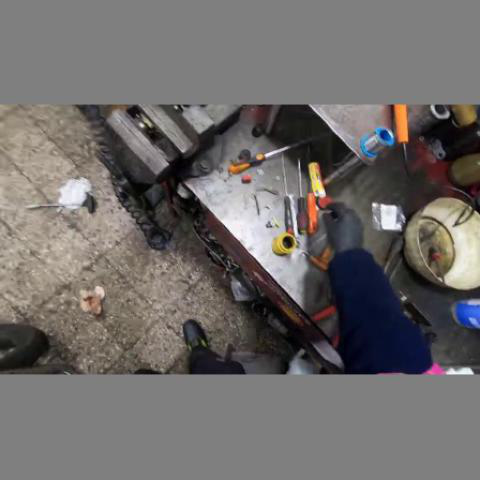

backbone
torch.Size([32768, 4]) torch.Size([4]) torch.Size([768, 4])
tensor([3688.8042, 1882.6971, 1868.3356, 1719.5637], device='cuda:0')


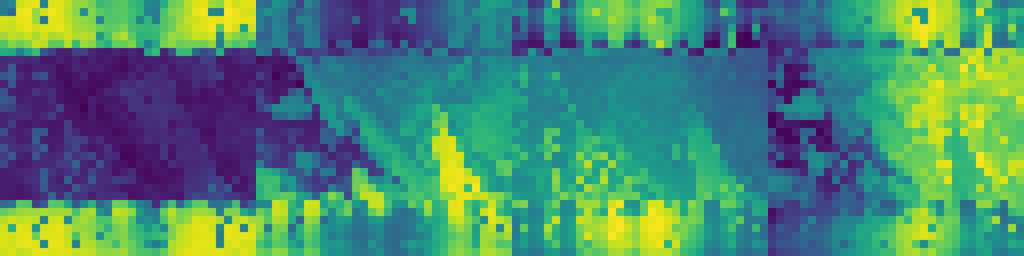

In [ ]:
def feats2score(feats, q=4):
    torch.manual_seed(42)
    feat = rearrange(feats, 't c h w -> (t h w) c')
    U, S, V = torch.pca_lowrank(feat, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat - feat.mean(dim=0)
    score_map = rearrange(_feat @ V, '(t h w) q -> t q h w', t=t, h=h, w=w)
    return score_map

def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 1000)
    return score_map

Q = 4
_, fidxs = torch.where(batch['gt_probs'] > 1e-3)
fidx = fidxs[len(fidxs) // 2 + 1].item()
display(ten2pil(batch['segment'][0, fidx]))

print('backbone')
score_map = feats2score(output_dict['feat']['clip']['backbone'], q=Q)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

# if reduce_key == 'reduce':
#     print('reduce')
#     score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q), ,,,,,asdasd
# 
# 
# 
# 
# 
# 
# 
# ,,,
#     images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
#     display(make_image_grid(images, rows=1, cols=len(images), resize=256))

# print('stx')
# score_map = feats2score(output_dict['feat']['clip']['stx'], q=Q)
# images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
# display(make_image_grid(images, rows=1, cols=len(images), resize=256))

# if reduce_key == 'late_reduce':
#     print('late_reduce')
#     score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q)
#     images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
#     display(make_image_grid(images, rows=1, cols=len(images), resize=256))

# if 'conv' in output_dict['feat']['clip']:
#     print('conv')
#     score_map = feats2score(output_dict['feat']['clip']['conv'], q=Q)
#     images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
#     display(make_image_grid(images, rows=1, cols=len(images), resize=256))

In [150]:
def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 10)
    return score_map
score_map = feats2score(output_dict['feat']['clip']['backbone'], q=Q)
score_map = gauss(score_map)
print(score_map.max(), score_map.mean(), score_map.std())
# print(score_map.topk(7))
# print(score_map.flatten(0).topk(7, largest=False))
torch.set_printoptions(precision=4, sci_mode=False, threshold=5, edgeitems=5, linewidth=1000)

display(score_map)



torch.Size([32768, 5]) torch.Size([5]) torch.Size([768, 5])
tensor([3688.3516, 1874.5060, 1807.2200, 1584.6010, 1409.5444], device='cuda:0')
tensor(1., device='cuda:0') tensor(0.8195, device='cuda:0') tensor(0.3065, device='cuda:0')


tensor([[[[    0.0565,     0.6363,     1.0000,     1.0000,     1.0000,  ...,     1.0000,     1.0000,     1.0000,     1.0000,     1.0000],
          [    0.6380,     0.4567,     1.0000,     1.0000,     1.0000,  ...,     0.6150,     1.0000,     1.0000,     1.0000,     1.0000],
          [    1.0000,     1.0000,     1.0000,     1.0000,     1.0000,  ...,     1.0000,     1.0000,     1.0000,     1.0000,     1.0000],
          [    1.0000,     1.0000,     1.0000,     1.0000,     1.0000,  ...,     1.0000,     1.0000,     1.0000,     1.0000,     1.0000],
          [    1.0000,     1.0000,     1.0000,     1.0000,     1.0000,  ...,     0.0026,     1.0000,     1.0000,     1.0000,     1.0000],
          ...,
          [    1.0000,     1.0000,     1.0000,     1.0000,     1.0000,  ...,     1.0000,     0.3254,     1.0000,     1.0000,     1.0000],
          [    1.0000,     1.0000,     1.0000,     1.0000,     0.9028,  ...,     0.5279,     1.0000,     1.0000,     0.1545,     1.0000],
          [    1.00

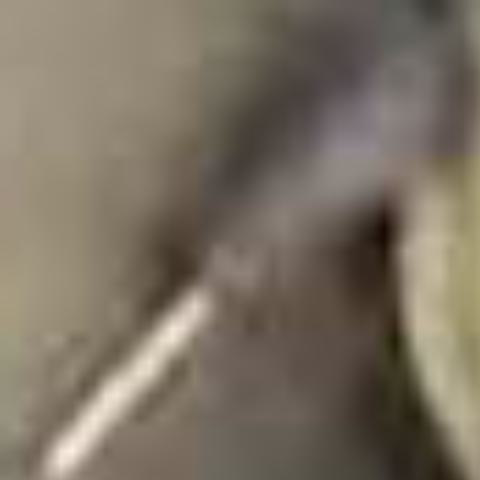

torch.Size([1024, 5]) torch.Size([5]) torch.Size([768, 5])
tensor([461.3744, 354.4850, 324.0696, 288.8771, 246.5483], device='cuda:0')


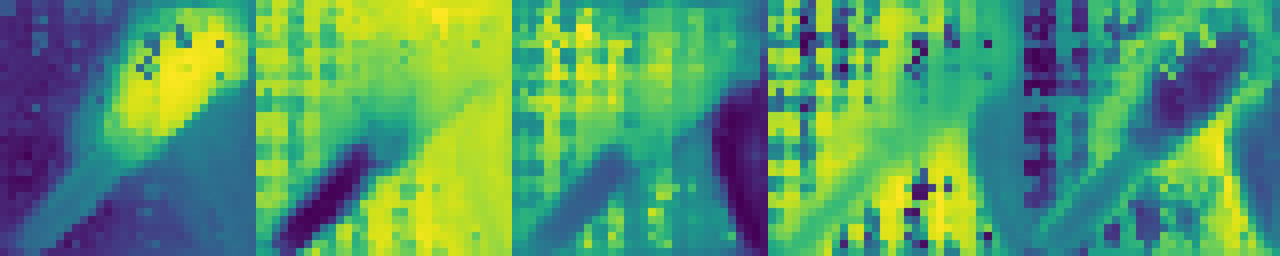

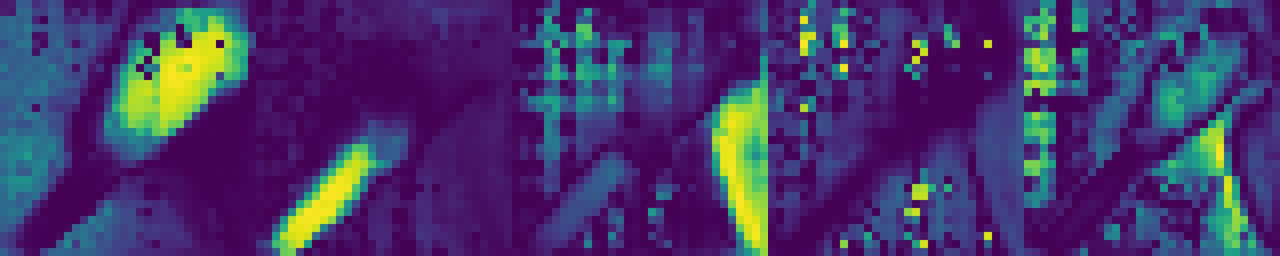

tensor([[[    0.0444,     0.0535,     0.1867,     0.1836,     0.0827,  ...,     0.1401,     0.1373,     0.1107,     0.0687,     0.0204],
         [    0.0497,     0.0412,     0.2154,     0.2233,     0.1262,  ...,     0.3079,     0.2232,     0.1775,     0.0865,     0.0179],
         [    0.2046,     0.2276,     0.1907,     0.2173,     0.0627,  ...,     0.4614,     0.3177,     0.2203,     0.1224,     0.0153],
         [    0.2064,     0.2340,     0.2046,     0.2680,     0.1691,  ...,     0.5543,     0.3700,     0.2913,     0.1924,     0.0149],
         [    0.2055,     0.2163,     0.1987,     0.2295,     0.0232,  ...,     0.6065,     0.5430,     0.4056,     0.3383,     0.1506],
         ...,
         [    0.2051,     0.2238,     0.1666,     0.0471,     0.0083,  ...,     0.0092,     0.0032,     0.0064,     0.0078,     0.0076],
         [    0.1949,     0.1600,     0.0765,     0.0135,     0.0057,  ...,     0.0234,     0.0040,     0.0084,     0.0101,     0.0157],
         [    0.1348,     0

In [144]:
def feat2pcscore(feat, q=4):
    torch.manual_seed(42)
    feat = rearrange(feat, 'c h w -> (h w) c')
    U, S, V = torch.pca_lowrank(feat, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat - feat.mean(dim=0)
    score_map = rearrange(_feat @ V, '(h w) q -> q h w', h=h, w=w)
    return score_map

def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 1000)
    return score_map

display(ten2pil(batch['query'][0]))

Q = 5

score_map = feat2pcscore(output_dict['feat']['query']['backbone'][0], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
torch.set_printoptions(precision=4, sci_mode=False, threshold=5, edgeitems=5, linewidth=1000)

display(score_map)

# score_map = feat2pcscore(output_dict['feat']['query'][reduce_key][0], q=Q)
# images = [ten2pil(score_map[q]) for q in range(Q)]
# display(make_image_grid(images, rows=1, cols=len(images), resize=256))
# score_map = gauss(score_map)
# images = [ten2pil(score_map[q]) for q in range(Q)]
# display(make_image_grid(images, rows=1, cols=len(images), resize=256))

In [159]:
output_dict['info_dict']['preds_top']['prob'].sigmoid()

tensor([[0.3324, 0.3199, 0.2779, 0.3136, 0.2944,  ..., 0.4294, 0.3999, 0.3697, 0.3788, 0.3266]], device='cuda:0')

torch.Size([32768, 5]) torch.Size([5]) torch.Size([256, 5])
tensor([260.8234, 210.7192, 175.3112, 138.5821, 130.2435], device='cuda:0')
99 196 163 238


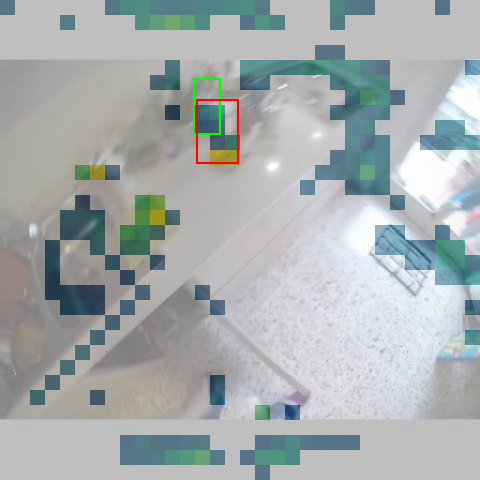

In [160]:
from PIL import ImageDraw

fidx = fidxs[0].item()
qidx = 1

score_map = feats2score(output_dict['feat']['clip']['stx'], q=Q)
score_map = gauss(score_map)
s = score_map[fidx, qidx]
s -= s.min()
s /= s.max()

image1 = ten2pil(batch['segment'][0, fidx]).convert('RGBA')
s_np = s.cpu().numpy()
image2 = ten2pil(s, alpha=(s_np > 0.3).astype(np.uint8))

image = Image.blend(image1, image2, alpha=0.5)
image.putalpha(255)


draw = ImageDraw.Draw(image)

y1, x1, y2, x2 = (batch['gt_bboxes'][0, fidx] * image.size[0]).cpu().numpy().astype(int)
draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=2)

# x1, y1, x2, y2 = (image.size[0] * output_dict['info_dict']['preds_top']['bbox'][0, fidx]).cpu().numpy().astype(int)
y1, x1, y2, x2 = (image.size[0] * output_dict['info_dict']['preds_top']['bbox'][0, fidx]).cpu().numpy().astype(int)
print(y1, x1, y2, x2)
draw.rectangle([(x1, y1), (x2, y2)], outline=(255, 0, 0), width=2)

image